<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">

<font size=6><b>Определение региона нефтедобычи</b></font><br><br>
<b>Описание:</b><br>
Нефтедобывающей компании нужно решить, где бурить новую скважину. Нужно определить регион с максимальной суммарной прибылью от скважин, отобранных по прогнозам модели.<br><br>

<b>Цель:</b><br>
Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.<br><br>
<b>Исходные данные:</b><br>
Данные геологоразведки трёх регионов находятся в трёх датасетах. Данные содержат информацию:
* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек;
* `product` — объём запасов в скважине (тыс. баррелей).<br><br>

<b>Условия:</b><br>
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд. рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.


<b>Содержание:</b><br>
1. Загрузка и подготовка данных:<br>
    1.1. Общая информация о данных;<br>
    1.2. Предообработка данных;<br>
    1.3. Исследование данных.<br><br>
2. Обучение и проверка моделей для каждого региона:<br>
    2.1. Разбивка данных на обучающую и валидационную выборки;<br>
    2.2. Обучение моделей и предсказания на валидационной выборке;<br>
    2.4. Вычисление среднего запаса предсказанного сырья и RMSE моделей;<br>
    2.5. Анализ результатов.<br><br>
3. Подготовка к расчёту прибыли:<br>
    3.1. Рассчёт достаточного объёма сырья для безубыточной разработки новой скважины;<br>
    3.2. Сравнение полученного объёма сырья со средним запасом в каждом регионе;<br>
    3.3. Анализ результатов.<br><br>
4. Разработка функции для расчёта прибыли по выбранным скважинам и предсказаниям модели:<br>
    4.1. Выбор скважины с максимальными значениями предсказаний;<br>
    4.2. Рассчёт целевого значение объёма сырья, соответствующее этим предсказаниям;<br>
    4.3. Рассчёт прибыли для полученного объёма сырья.<br><br>
5. Расчёт рисков и прибыли для каждого региона:<br>
    5.1. Расчёт распределения прибыли методом Bootstrap;<br>
    5.2. Расчёт средней прибыли, 95%-й доверительного интервала и риска убытков;<br>
    5.3. Выводы.

## 1. Загрузка и подготовка данных

### 1.1 Общая информация о данных

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Импорт библиотек, загрузка данных, изучение общей информации о данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

rstate = 5903

In [2]:
df0 = pd.read_csv('geo_data_0.csv')
df1 = pd.read_csv('geo_data_1.csv')
df2 = pd.read_csv('geo_data_2.csv')
    
# словарь датафреймов
df_dict = {'geo_data_0': df0,
           'geo_data_1': df1,
           'geo_data_2': df2}

numeric_features = df0.select_dtypes(float).columns

In [3]:
# функция выводит общие данные о датафрейме
def get_data_info(data):
    print(f'Количество объектов: {data.shape[0]}\nКоличество признаков: {data.shape[1]}')
    display(data.head())
    display(data.info())
    print()

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Выведем общую информацию о датафреймах.

In [4]:
for df_name, df in df_dict.items():
    print('************\n', df_name, '\n************')
    get_data_info(df)

************
 geo_data_0 
************
Количество объектов: 100000
Количество признаков: 5


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


************
 geo_data_1 
************
Количество объектов: 100000
Количество признаков: 5


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


************
 geo_data_2 
************
Количество объектов: 100000
Количество признаков: 5


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

### 1.2 Предобработка данных

#### 1.2.1 Обработка пропусков

In [5]:
for df_name, df in df_dict.items():
    print('************\n', df_name, '\n************')
    display(df.isna().sum())

************
 geo_data_0 
************


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

************
 geo_data_1 
************


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

************
 geo_data_2 
************


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Пропущенных значений не обнаружено.

#### 1.2.2 Обработка аномальных значений

In [6]:
# функция строит boxplot для четырёх признаков
def show_boxes(data, name):
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows = 1,  ncols = 4, figsize = (12, 6))    
    sns.boxplot(y=data['f0'], ax = ax0)
    ax0.set_title('f0', fontsize = 14)
    sns.boxplot(y=data['f1'], ax = ax1)
    ax1.set_title('f1', fontsize = 14)
    sns.boxplot(y=data['f2'], ax = ax2)
    ax2.set_title('f2', fontsize = 14)
    sns.boxplot(y=data['product'], ax = ax3)
    ax3.set_title('product', fontsize = 14)
    fig.suptitle(name, fontsize=20)
    plt.tight_layout()  
    plt.show()

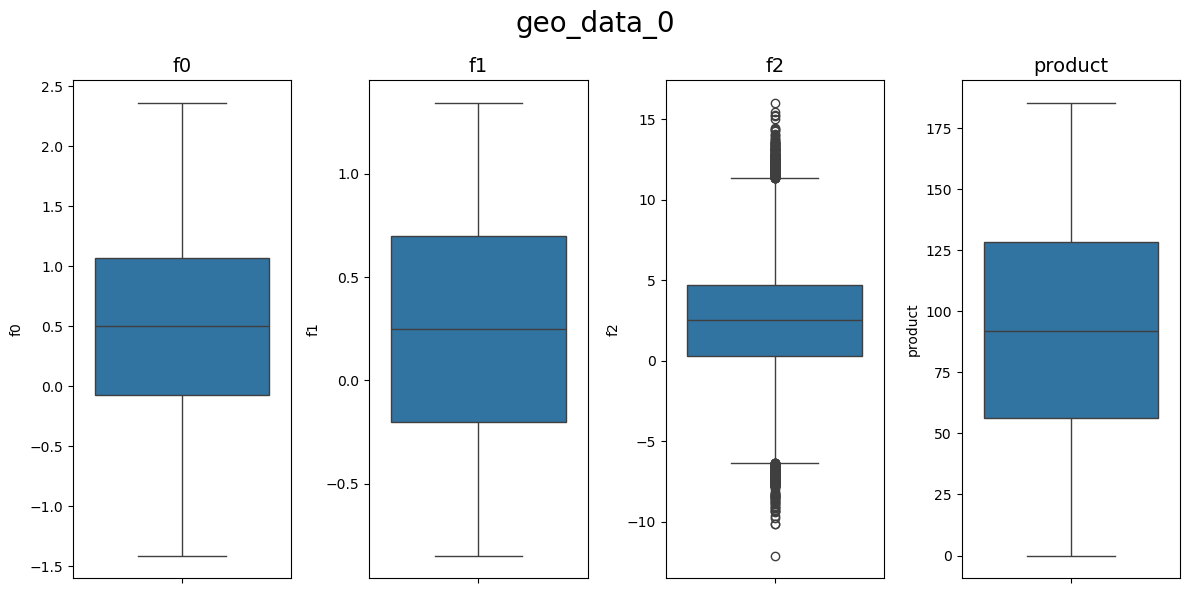

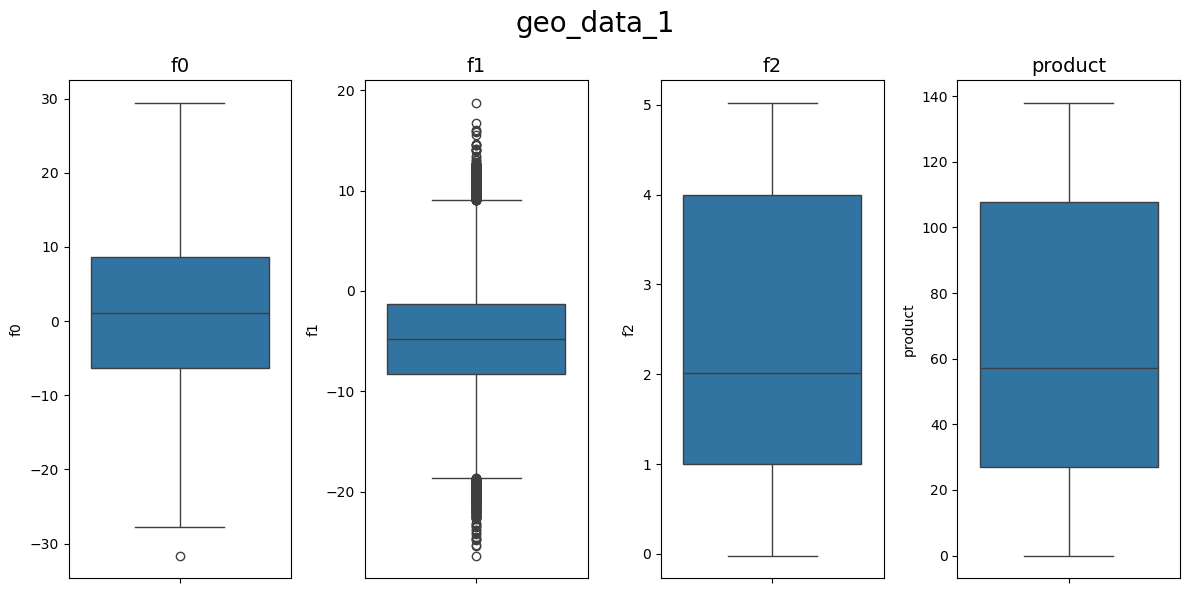

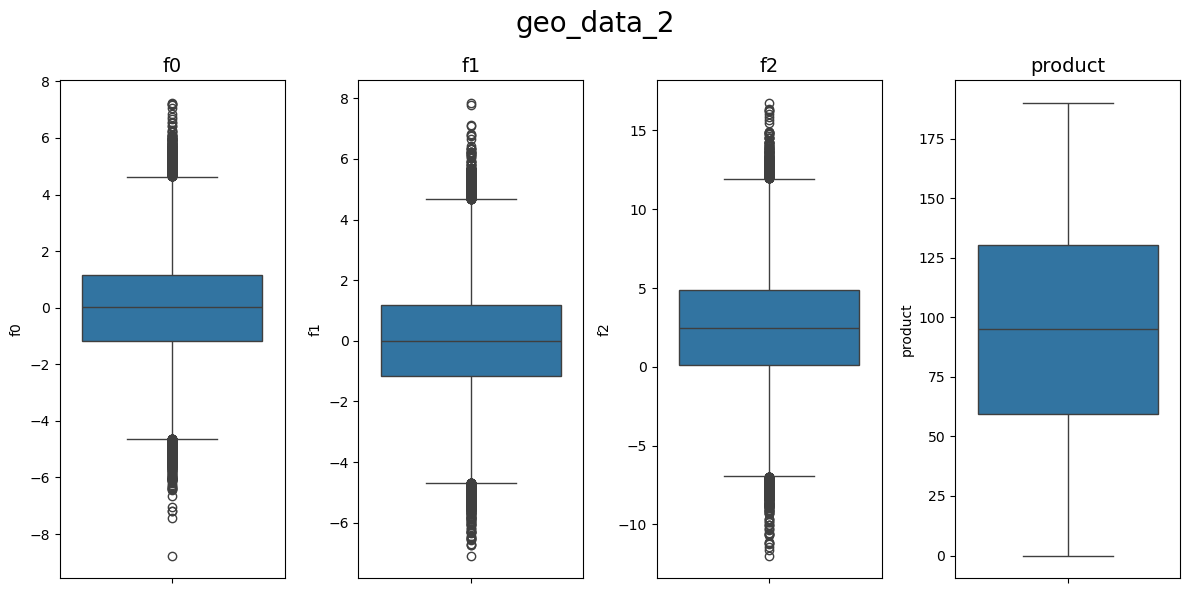

In [7]:
for df_name, df in df_dict.items():
    show_boxes(df, df_name)

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
У всех датасетов есть выбросы в разных признаках. Но причин для их удаления нет, так как это могу быть реальные действительные данные.

#### 1.2.3 Обработка дубликатов

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Дубликаты могут быть только в столбце **id**. Проверим его.

In [8]:
for df_name, df in df_dict.items():
    print(f'{df_name} : {df.duplicated(subset="id").sum()} пар дубликатов')
    print(df[df.duplicated(subset='id', keep=False)]['id'].sort_values())
    print()

geo_data_0 : 10 пар дубликатов
66136    74z30
64022    74z30
51970    A5aEY
3389     A5aEY
69163    AGS9W
42529    AGS9W
931      HZww2
7530     HZww2
63593    QcMuo
1949     QcMuo
75715    Tdehs
21426    Tdehs
92341    TtcGQ
60140    TtcGQ
89582    bsk9y
97785    bsk9y
41724    bxg6G
1364     bxg6G
16633    fiKDv
90815    fiKDv
Name: id, dtype: object

geo_data_1 : 4 пар дубликатов
5849     5ltQ6
84461    5ltQ6
1305     LHZR0
41906    LHZR0
2721     bfPNe
82178    bfPNe
47591    wt4Uk
82873    wt4Uk
Name: id, dtype: object

geo_data_2 : 4 пар дубликатов
45404    KUPhW
55967    KUPhW
11449    VF7Jo
49564    VF7Jo
44378    Vcm5J
95090    Vcm5J
28039    xCHr8
43233    xCHr8
Name: id, dtype: object



<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Проверка на дубликаты выявила в каждом наборе данных несколько пар дублирующих по **id** объектов. Так как этот параметр не может повторяться (разные скважины), то дубликаты должны быть удалены. У каждой пары дубликатов сильно различаются остальные признаки, что не позволяет решить, какой объект оставить. Поэтому все дубликаты подлежат удалению, тем более, их немного.

In [9]:
df0 = df0.drop_duplicates(subset='id', keep=False)
df1 = df1.drop_duplicates(subset='id', keep=False)
df2 = df2.drop_duplicates(subset='id', keep=False)

In [10]:
df0.shape[0], df1.shape[0], df2.shape[0]

(99980, 99992, 99992)

### 1.3 Исследование данных

In [11]:
display(df0.describe())
display(df1.describe())
display(df2.describe())

,f0,f1,f2,product
count,99980.000000,99980.000000,99980.000000,99980.000000
mean,0.500447,0.250147,2.502638,92.499166
std,0.871879,0.504431,3.248056,44.289044
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072674,-0.200869,0.288010,56.496513
50%,0.502374,0.250252,2.516005,91.847928
75%,1.073692,0.700646,4.714884,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,99992.000000,99992.000000,99992.000000,99992.000000
mean,1.141363,-4.796522,2.494511,68.824148
std,8.965805,5.119934,1.703587,45.944889
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298525,-8.267985,1.000021,26.953261
50%,1.153190,-4.813005,2.011475,57.085625
75%,8.620964,-1.332704,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,99992.000000,99992.000000,99992.000000,99992.000000
mean,0.001975,-0.002113,2.495088,94.998767
std,1.732061,1.730404,3.473491,44.747763
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174820,0.130269,59.450441
50%,0.009411,-0.009580,2.484236,94.925026
75%,1.158442,1.163592,4.858662,130.585544
max,7.238262,7.844801,16.739402,190.029838


<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Рассмотрим, как распределены признаки в трёх датасетах.

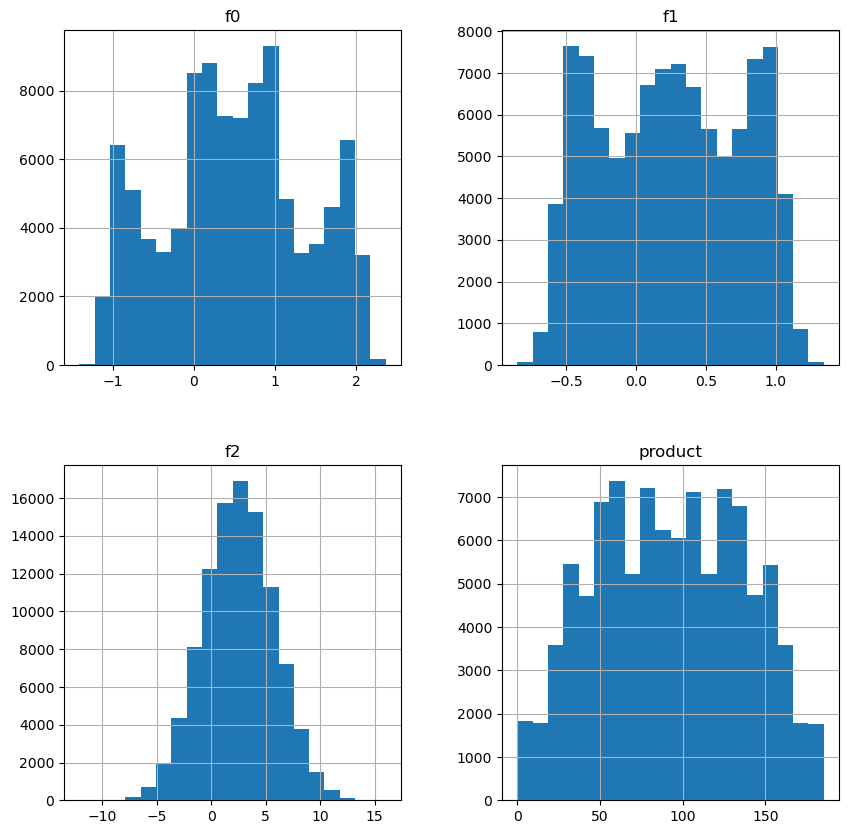

In [12]:
df0.hist(bins=20, figsize=(10, 10));

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Признаки **f0**, **f1** и **product** ненормально распределены (прослеживается несколько мод).<br>
Признак **f2** распределён нормально.

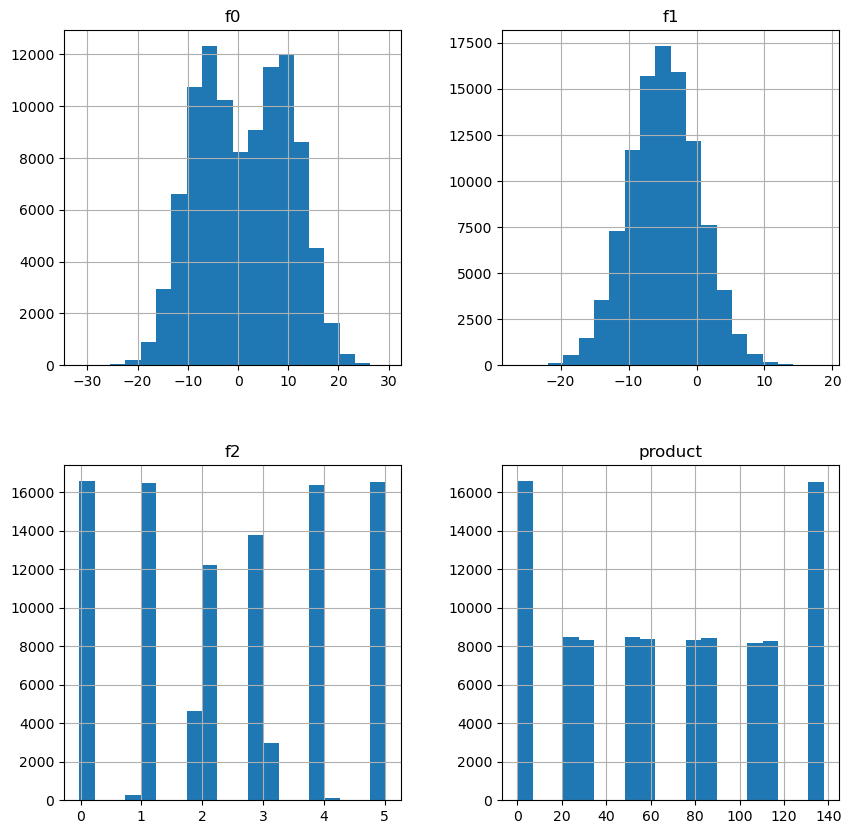

In [13]:
df1.hist(bins=20, figsize=(10, 10));

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Признаки **f0** распределён бимодально.<br>
Признак **f1** распределён нормально.<br>
Признаки **f2** и **product** распределены мультимодально (почти дискретные значения). 

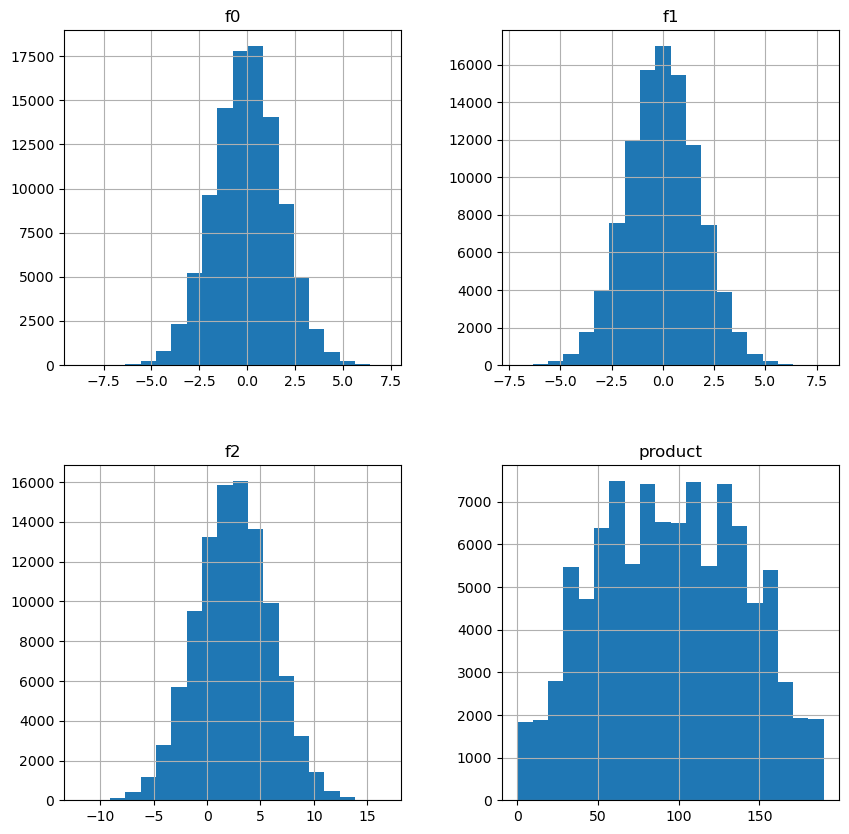

In [14]:
df2.hist(bins=20, figsize=(10, 10));

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Признаки **f0**, **f1** и **f2** распределены нормально.<br>
Признак **product** ненормально распределён (плосковершинное распределение).

Корреляция признаков.

In [16]:
df0.corr(numeric_only=True).style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,f0,f1,f2,product
f0,1.000000,-0.440724,-0.003204,0.143504
f1,-0.440724,1.000000,0.001783,-0.192338
f2,-0.003204,0.001783,1.000000,0.483628
product,0.143504,-0.192338,0.483628,1.000000


<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Умеренно-положительная корреляция между признаками **product** и **f2**.<br>
Умеренно-отрицательная корреляция между признаками **f0** и **f1**.<br>

In [17]:
df1.corr(numeric_only=True).style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,f0,f1,f2,product
f0,1.000000,0.182263,-0.001821,-0.030534
f1,0.182263,1.000000,-0.002608,-0.010167
f2,-0.001821,-0.002608,1.000000,0.999397
product,-0.030534,-0.010167,0.999397,1.000000


<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Практическая полная положительная корреляция между признаками **product** и **f2**.<br>

In [18]:
df2.corr(numeric_only=True).style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,f0,f1,f2,product
f0,1.000000,0.000501,-0.000454,-0.001974
f1,0.000501,1.000000,0.000763,-0.001046
f2,-0.000454,0.000763,1.000000,0.445873
product,-0.001974,-0.001046,0.445873,1.000000


<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Умеренно-положительная корреляция между признаками **product** и **f2**.<br>

### 1.3 Вывод 1

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">

* Исходные данные содержат информацию о 5 признаках у 100000 объектов;
* Типы данных: категориальные (`id`) и непрерывные (`f0`, `f1`, `f2` , `product`);
* Целевой признак - **`product`**;
* объекты с пропущенными значениями не найдены;
* дубликаты были удалены;
* выбросы определены и удалены;
* данные для трёх месторождений отличаются, особенно второе (заметно меньше средний объём запасов);
* признаки в трёх наборах данных распределены по разному;
* между признаками прослеживается корреляция (в т.ч. и с целевым признаком);

## 2. Обучение и проверка моделей для каждого региона

### 2.1 Разделение выборки

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Разделим исходные данные на целевой признак и признаки для обучения, а потом  на три части: обучающая, валидационная и тестовая - в пропорции 75/25.

In [19]:
# функция разделяет входные данные на четыре части
def split_data(data):
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    return train_test_split(features, target, test_size=0.25, random_state=rstate)

In [20]:
X_train0, X_valid0, y_train0, y_valid0 = split_data(df0)
print('geo_data_0')
print(f'Размер обучающей выборки:\t{X_train0.shape}')
print(f'Размер валидационной выборки:\t{X_valid0.shape}')

X_train1, X_valid1, y_train1, y_valid1 = split_data(df1)
print('geo_data_1')
print(f'Размер обучающей выборки:\t{X_train1.shape}')
print(f'Размер валидационной выборки:\t{X_valid1.shape}')

X_train2, X_valid2, y_train2, y_valid2 = split_data(df2)
print('geo_data_2')
print(f'Размер обучающей выборки:\t{X_train2.shape}')
print(f'Размер валидационной выборки:\t{X_valid2.shape}')

geo_data_0
Размер обучающей выборки:	(74985, 3)
Размер валидационной выборки:	(24995, 3)
geo_data_1
Размер обучающей выборки:	(74994, 3)
Размер валидационной выборки:	(24998, 3)
geo_data_2
Размер обучающей выборки:	(74994, 3)
Размер валидационной выборки:	(24998, 3)


### 2.2 Масштабирование числовых данных в выборках

In [21]:
# нормализация двух наборов данных с сохранением индексов и названий колонок
def scale_data(data_train, data_valid):
    scaler = StandardScaler()
    scaler.fit(data_train)
    return pd.DataFrame(scaler.transform(data_train), index=data_train.index, columns=data_train.columns), \
           pd.DataFrame(scaler.transform(data_valid), index=data_valid.index, columns=data_valid.columns)

In [22]:
X_train0, X_valid0 = scale_data(X_train0, X_valid0)
X_train1, X_valid1 = scale_data(X_train1, X_valid1)
X_train2, X_valid2 = scale_data(X_train2, X_valid2)

display(X_train0.agg(['mean', 'std']).round(2))
display(X_train1.agg(['mean', 'std']).round(2))
display(X_train2.agg(['mean', 'std']).round(2))

,f0,f1,f2
mean,0.0,0.0,-0.0
std,1.0,1.0,1.0


,f0,f1,f2
mean,0.0,-0.0,0.0
std,1.0,1.0,1.0


,f0,f1,f2
mean,0.0,0.0,0.0
std,1.0,1.0,1.0


### 2.3 Обучение моделей

In [23]:
# функция получает на вход признаки для обучения и предсказания
# возвращает обученную модель и предсказанные значения
def get_linreg_prediction(data_train, target_train, data_valid):
    model = LinearRegression()
    model.fit(data_train, target_train)
    pred_valid = model.predict(data_valid)
    return model, pred_valid

In [24]:
model0, predicted_valid0 = get_linreg_prediction(X_train0, y_train0, X_valid0)
pred_mean0 = predicted_valid0.mean()
rmse0 = mean_squared_error(y_valid0, predicted_valid0, squared=False)
print(f'Mean predicted product = {pred_mean0:.2f}, rmse = {rmse0:.2f}')

model1, predicted_valid1 = get_linreg_prediction(X_train1, y_train1, X_valid1)
pred_mean1 = predicted_valid1.mean()
rmse1 = mean_squared_error(y_valid1, predicted_valid1, squared=False)
print(f'Mean predicted product = {pred_mean1:.2f}, rmse = {rmse1:.2f}')

model2, predicted_valid2 = get_linreg_prediction(X_train2, y_train2, X_valid2)
pred_mean2 = predicted_valid2.mean()
rmse2 = mean_squared_error(y_valid2, predicted_valid2, squared=False)
print(f'Mean predicted product = {pred_mean2:.2f}, rmse = {rmse2:.2f}')

Mean predicted product = 92.38, rmse = 37.47
Mean predicted product = 68.34, rmse = 0.89
Mean predicted product = 94.93, rmse = 40.18


### 2.4 Выводы 2

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">

* Предсказания линейной регрессии для регионов **0** и **2** дают близкие результаты по среднему значению объёмов запаса (в исходных данных этот факт также прослеживается), но при этом очень большая ошибка rmse;
* Предсказания для региона **1** дают более низкое среднее значением объёмов запаса, но ошибка rmse значительно меньше, что говорит о большей надёжности сделанных предсказаний.

## 3. Расчёт достаточного объёма сырья

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Рассчитаем достаточный объём сырья для безубыточной разработки новых скважин для каждого региона.

In [25]:
# бюджет на разработку [рублей]
DEV_BUDGET = 10e9
# бюджет на разработку [рублей / тыс. баррелей]
PRICE = 450000
# количество исследуемых скважин
WELL_AMOUNT = 500
# количество лучших скважин, которые и будут разрабатываться
BEST_WELL_AMOUNT = 200
# количество samples для Bootstrap
N_SAMPLES = 1000

# достаточный объём сырья для одной скважины [тыс. баррелей] для достижения безубыточности
suff_amount_1well = DEV_BUDGET / PRICE / BEST_WELL_AMOUNT
print(f'Безубыточный объём сырья: {suff_amount_1well:.1f} тыс. баррелей на одну скважину')

Безубыточный объём сырья: 111.1 тыс. баррелей на одну скважину


<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
Сравним полученный объём сырья со средним запасом в каждом регионе.

In [26]:
print(f'Средний объём сырья в регионе 0: {df0["product"].mean():.1f} тыс. баррелей на одну скважину')
print(f'Средний объём сырья в регионе 1: {df1["product"].mean():.1f} тыс. баррелей на одну скважину')
print(f'Средний объём сырья в регионе 2: {df2["product"].mean():.1f} тыс. баррелей на одну скважину')

Средний объём сырья в регионе 0: 92.5 тыс. баррелей на одну скважину
Средний объём сырья в регионе 1: 68.8 тыс. баррелей на одну скважину
Средний объём сырья в регионе 2: 95.0 тыс. баррелей на одну скважину


<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">

* Чтобы скважина была безубыточной, её запасы сырья должны быть не меньше **111.1 тыс.** баррелей;
* В среднем скважины ни в одном из регионов не соответствуют этому критерию (для 200 скважин);
* Поэтому необходимо найти и отобрать **200 лучших** скважин, чтобы сделать месторождение безубыточным;

## 4. Функция расчёта прибыли по лучшим предсказанным скважинам

In [27]:
# функция получает на вход целевой признак и предсказанные значения
# возвращает суммарную чистую прибыль для 200 лучших скважин
def calculate_netprofit(target, pred_data):
    data = pd.DataFrame({'target': target, 'predicted': pred_data})
    volume_biggest200 = data.sort_values(by='predicted', ascending=False)[:BEST_WELL_AMOUNT]['target'].sum()
    return volume_biggest200 * PRICE - DEV_BUDGET

## 5. Расчёт рисков и прибыли для регионов

### 5.1 Распределение прибыли

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">
    
Найдём распределение прибыли техникой Bootstrap: создадим 1000 выборок из **пятисот** скважин и рассчитаем прибыль для **двухсот** лучших по предсказаниям модели для каждого региона.

In [28]:
# фунцкия принимает на вход обученную модель, валидационные признаки и целевой признак
# возвращает объект Series с чистой прибылью для каждого sample
def get_netprofit_distr(modeln, X_valid, y_valid):
    state = np.random.RandomState(rstate)
    netprofit_values = []
    for i in range(N_SAMPLES):
        y_valid_sample = y_valid.sample(n=WELL_AMOUNT, replace=True, random_state=state)
        X_valid_sample = X_valid.loc[y_valid_sample.index]
        predicted_sample = modeln.predict(X_valid_sample)    
        netprofit_values.append(calculate_netprofit(y_valid_sample, predicted_sample))
    return pd.Series(netprofit_values)

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">

Построим распределение чистой прибыли для каждого региона.

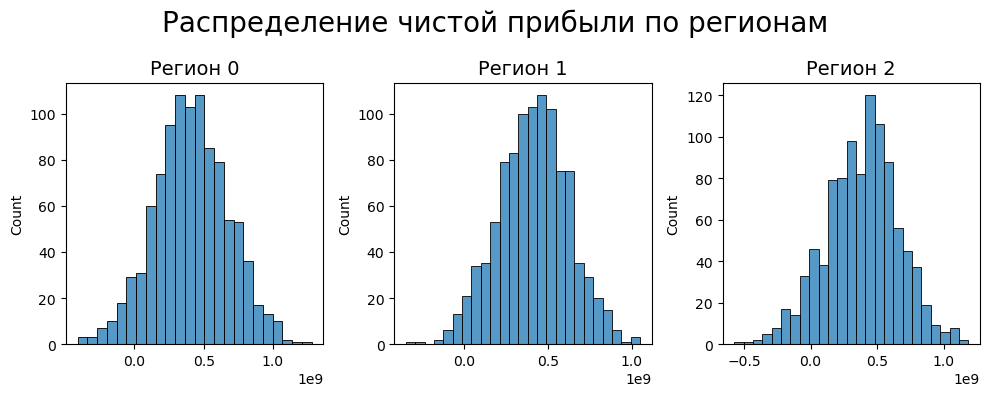

In [29]:
netprofit0_distr = get_netprofit_distr(model0, X_valid0, y_valid0)
netprofit1_distr = get_netprofit_distr(model1, X_valid1, y_valid1)
netprofit2_distr = get_netprofit_distr(model2, X_valid2, y_valid2)

fig, (ax0, ax1, ax2) = plt.subplots(nrows = 1,  ncols = 3, figsize = (10, 4))    
sns.histplot(netprofit0_distr, ax = ax0)
ax0.set_title('Регион 0', fontsize = 14)
sns.histplot(netprofit1_distr, ax = ax1)
ax1.set_title('Регион 1', fontsize = 14)
sns.histplot(netprofit2_distr, ax = ax2)
ax2.set_title('Регион 2', fontsize = 14)
fig.suptitle('Распределение чистой прибыли по регионам', fontsize=20)
plt.tight_layout()  
plt.show()

### 5.2 Статистики распределения прибыли

In [30]:
# функция печатает статистики распределения прибыли
def show_distr_stats(distr):
    print(f'Средняя чистая прибыль: {distr.mean() / 1e9 :.3f} млрд. рублей')
    print(f'95% доверительный интервал: ({distr.quantile(q=0.025) / 1e9 :.3f}, {distr.quantile(q=0.975) / 1e9 :.3f}) млрд. рублей')
    risk_of_loss = (distr < 0).mean()
    if risk_of_loss > 0.025:
        print(f'Риск убыков: {risk_of_loss:.2%} => НЕ соответствует критерию\n')
    else:
        print(f'Риск убыков: {risk_of_loss:.2%} => соответствует критерию\n')

In [31]:
print('Регион 0')
show_distr_stats(netprofit0_distr)
print('Регион 1')
show_distr_stats(netprofit1_distr)
print('Регион 2')
show_distr_stats(netprofit2_distr)

Регион 0
Средняя чистая прибыль: 0.410 млрд. рублей
95% доверительный интервал: (-0.117, 0.932) млрд. рублей
Риск убыков: 6.20% => НЕ соответствует критерию

Регион 1
Средняя чистая прибыль: 0.412 млрд. рублей
95% доверительный интервал: (-0.006, 0.819) млрд. рублей
Риск убыков: 2.90% => НЕ соответствует критерию

Регион 2
Средняя чистая прибыль: 0.386 млрд. рублей
95% доверительный интервал: (-0.193, 0.898) млрд. рублей
Риск убыков: 8.40% => НЕ соответствует критерию



## 6. Выводы

<div style="border:solid MidnightBlue 2px; padding: 20px; border-radius: 10px">

По результатам моделирования можно заключить, что во **всех регионах** риск убытков **больше** требуемого критерия (< 2.5%). При этом в **регионе 1** самый высокий средний уровень чистой прибыли (0.412 млрд. рублей) и самый низкий риск убытков (2.9%). Исходя из представленных данных нет возможности порекомендовать какой-либо из регионов.